# Klasifikasi ECOLI



In [ ]:
import mysql.connector
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


In [ ]:
conn = mysql.connector.connect(
  host='127.0.0.1',
  user='root',
  password='',
  database='ecoli'
)

df = pd.read_sql("SELECT * FROM ecoli", conn)
print("\nIsi tabel ecoli:")
print(df)


Isi tabel ecoli:
      id protein_name   mcg   gvh   lip  chg   aac  alm1  alm2  \
0      1    AAT_ECOLI  0.49  0.29  0.48  0.5  0.56  0.24  0.35   
1      2   ACEA_ECOLI  0.07  0.40  0.48  0.5  0.54  0.35  0.44   
2      3   ACEK_ECOLI  0.56  0.40  0.48  0.5  0.49  0.37  0.46   
3      4   ACKA_ECOLI  0.59  0.49  0.48  0.5  0.52  0.45  0.36   
4      5    ADI_ECOLI  0.23  0.32  0.48  0.5  0.55  0.25  0.35   
..   ...          ...   ...   ...   ...  ...   ...   ...   ...   
331  332   TREA_ECOLI  0.74  0.56  0.48  0.5  0.47  0.68  0.30   
332  333   UGPB_ECOLI  0.71  0.57  0.48  0.5  0.48  0.35  0.32   
333  334   USHA_ECOLI  0.61  0.60  0.48  0.5  0.44  0.39  0.38   
334  335   XYLF_ECOLI  0.59  0.61  0.48  0.5  0.42  0.42  0.37   
335  336   YTFQ_ECOLI  0.74  0.74  0.48  0.5  0.31  0.53  0.52   

    localization_class  
0                   cp  
1                   cp  
2                   cp  
3                   cp  
4                   cp  
..                 ...  
331           

C:\Users\Syafiq Azizi\AppData\Local\Temp\ipykernel_28416\3300115334.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql("SELECT * FROM ecoli", conn)


Jumlah pada tiap kelas di kolom localization_class:
localization_class
cp     143
im      77
pp      52
imU     35
om      20
omL      5
imS      2
imL      2
Name: count, dtype: int64


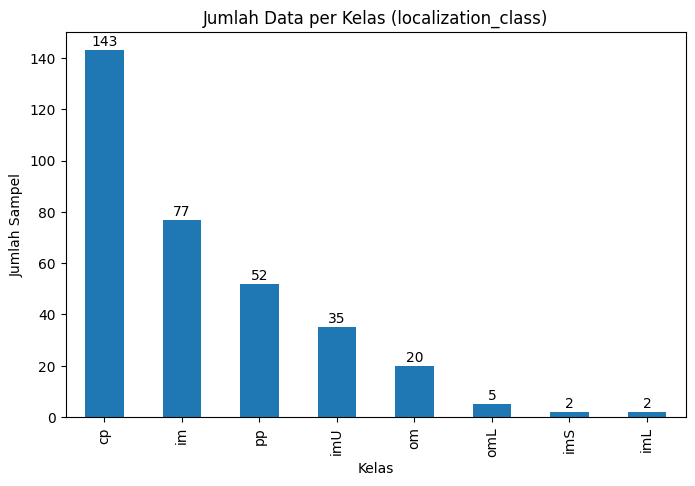

In [ ]:
species_counts = df['localization_class'].value_counts()

print("Jumlah pada tiap kelas di kolom localization_class:")
print(species_counts)

plt.figure(figsize=(8,5))
species_counts.plot(kind='bar')

plt.xlabel("Kelas")
plt.ylabel("Jumlah Sampel")
plt.title("Jumlah Data per Kelas (localization_class)")

for i, v in enumerate(species_counts):
    plt.text(i, v + 0.5, str(v), ha='center', va='bottom')

plt.show()


explained variance ratio (first two components): [9.99985274e-01 8.13542487e-06]


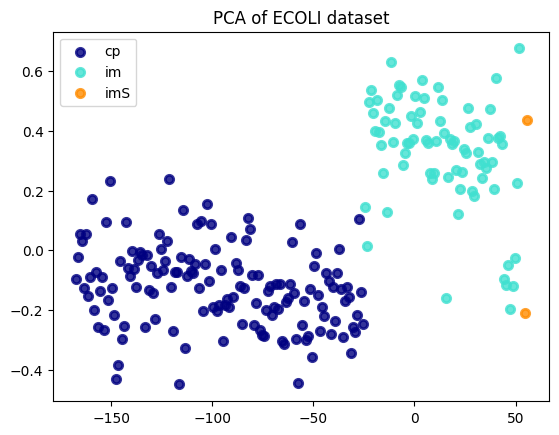

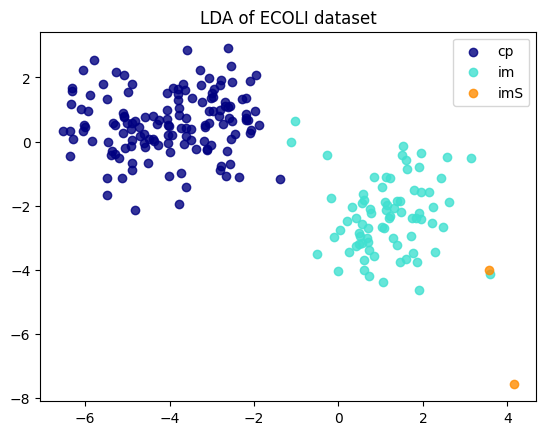

In [ ]:
X = df.drop(columns=["protein_name", "localization_class"]).values
y = df["localization_class"].astype("category").cat.codes.values
target_names = df["localization_class"].unique()

pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

lda = LinearDiscriminantAnalysis(n_components=2)
X_r2 = lda.fit(X, y).transform(X)

print(
    "explained variance ratio (first two components): %s"
    % str(pca.explained_variance_ratio_)
)

plt.figure()
colors = ["navy", "turquoise", "darkorange"]
lw = 2

for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(
        X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=0.8, lw=lw, label=target_name
    )
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("PCA of ECOLI dataset")

plt.figure()
for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(
        X_r2[y == i, 0], X_r2[y == i, 1], alpha=0.8, color=color, label=target_name
    )
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("LDA of ECOLI dataset")

plt.show()

In [ ]:
to_drop = [c for c in ["id", "protein_name", "sequence_name"] if c in df.columns]
if to_drop:
    print("\nDropping identifier columns:", to_drop)
    df = df.drop(columns=to_drop)


Dropping identifier columns: ['id', 'protein_name']


In [ ]:
print("Total baris (raw):", len(df))

df.columns = df.columns.str.strip()
print("\nKolom dan dtypes awal:")
print(df.dtypes)

target_col = "localization_class"
if target_col not in df.columns:
    raise KeyError(f"Kolom target '{target_col}' tidak ditemukan. Kolom yang tersedia: {df.columns.tolist()}")

drop_cols = [c for c in ["id", "protein_name", "sequence_name"] if c in df.columns]
if drop_cols:
    print("Menghapus kolom identifier:", drop_cols)
    df = df.drop(columns=drop_cols)

expected = ["mcg","gvh","lip","chg","aac","alm1","alm2"]
avail_expected = [c for c in expected if c in df.columns]
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

if avail_expected:
    features = avail_expected
    print("Menggunakan fitur expected:", features)
else:
    features = [c for c in numeric_cols if c != target_col]
    print("Fitur numerik terdeteksi:", features)

if not features:
    raise ValueError("Tidak ada fitur numerik yang tersedia. Periksa kembali dataframe.")

for c in features:
    df[c] = pd.to_numeric(df[c], errors="coerce")

print("\nJumlah NaN per fitur setelah coercion:")
print(df[features].isna().sum())

before = len(df)
df = df.dropna(subset=features + [target_col])
after = len(df)
print(f"Dropped {before-after} baris yang bermasalah. Sisa baris: {len(df)}")

non_numeric_in_X = [c for c in features if not pd.api.types.is_numeric_dtype(df[c])]
if non_numeric_in_X:
    print("Masih ada kolom non-numeric:", non_numeric_in_X)
    raise ValueError("Masih ada fitur non-numeric. Periksa data sumber.")

X = df[features].copy()
le = LabelEncoder()
y = le.fit_transform(df[target_col])
print("\nFitur final (X):", X.columns.tolist())
print("Tipe X:\n", X.dtypes)
print("Kelas target:", list(le.classes_))
print("Distribusi kelas (sebelum split):")
print(pd.Series(y).map({i:c for i,c in enumerate(le.classes_)}).value_counts())

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)



Total baris (raw): 336

Kolom dan dtypes awal:
mcg                   float64
gvh                   float64
lip                   float64
chg                   float64
aac                   float64
alm1                  float64
alm2                  float64
localization_class     object
dtype: object
Menggunakan fitur expected: ['mcg', 'gvh', 'lip', 'chg', 'aac', 'alm1', 'alm2']

Jumlah NaN per fitur setelah coercion:
mcg     0
gvh     0
lip     0
chg     0
aac     0
alm1    0
alm2    0
dtype: int64
Dropped 0 baris yang bermasalah. Sisa baris: 336

Fitur final (X): ['mcg', 'gvh', 'lip', 'chg', 'aac', 'alm1', 'alm2']
Tipe X:
 mcg     float64
gvh     float64
lip     float64
chg     float64
aac     float64
alm1    float64
alm2    float64
dtype: object
Kelas target: ['cp', 'im', 'imL', 'imS', 'imU', 'om', 'omL', 'pp']
Distribusi kelas (sebelum split):
cp     143
im      77
pp      52
imU     35
om      20
omL      5
imS      2
imL      2
Name: count, dtype: int64


In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Latih model
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)

# Evaluasi
print("Naive Bayes")
print("Accuracy:", accuracy_score(y_test, y_pred_nb))

Naive Bayes
Accuracy: 0.7920792079207921


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Latih model
rf = RandomForestClassifier(random_state=42, n_estimators=100)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Evaluasi
print("Random Forest")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))

Random Forest
Accuracy: 0.8217821782178217


In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# Latih model
bag = BaggingClassifier(
    estimator=DecisionTreeClassifier(random_state=42),
    n_estimators=100,
    random_state=42
)
bag.fit(X_train, y_train)
y_pred_bag = bag.predict(X_test)

# Evaluasi
print("Bagging Classifier")
print("Accuracy:", accuracy_score(y_test, y_pred_bag))

Bagging Classifier
Accuracy: 0.8217821782178217



=== Perbandingan Akurasi ===
Naive Bayes: 0.7921
Random Forest: 0.8218
Bagging Classifier: 0.8218


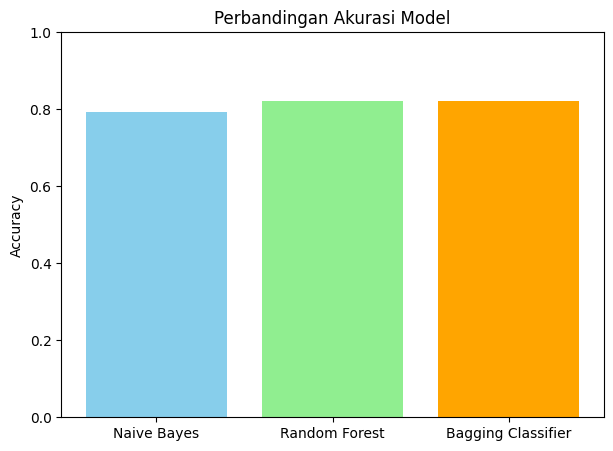

In [ ]:
accuracies = {
    "Naive Bayes": accuracy_score(y_test, y_pred_nb),
    "Random Forest": accuracy_score(y_test, y_pred_rf),
    "Bagging Classifier": accuracy_score(y_test, y_pred_bag)
}

print("\n=== Perbandingan Akurasi ===")
for model, acc in accuracies.items():
    print(f"{model}: {acc:.4f}")

plt.figure(figsize=(7,5))
plt.bar(accuracies.keys(), accuracies.values(), color=["skyblue", "lightgreen", "orange"])
plt.title("Perbandingan Akurasi Model")
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.show()
